In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/har25indoor/HARDATA_SHREYA/desktop.ini
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_161.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_206.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_153.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_102.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_002.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_012.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_134.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_052.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_148.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_136.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_165.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_041.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_205.jp

In [2]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset, Dataset
from transformers import AutoImageProcessor, EfficientNetForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import DefaultDataCollator
import torch
import evaluate
import numpy as np
import os

2024-08-24 16:51:21.214865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 16:51:21.214986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 16:51:21.323991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set PyTorch CUDA environment variable to avoid memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Load the dataset
data = load_dataset("imagefolder", data_dir='/kaggle/input/har25indoor/HARDATA_SHREYA')
reduced_dataset = data['train'].select(range(5400))

# Create a new dataset from the reduced dataset
new_dataset = Dataset.from_dict(reduced_dataset[:])

print(new_dataset)

Resolving data files:   0%|          | 0/5480 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 5400
})


In [5]:
dataset = new_dataset.train_test_split(test_size=0.2)
labels = set(dataset['train']['label'])

# Create label to id and id to label mappings
label2id, id2label = dict(), dict()
for i, label in enumerate(sorted(labels)):  # sorted to ensure consistent ordering
    label2id[label] = str(i)
    id2label[str(i)] = label

In [6]:
# Load the image processor
checkpoint = "google/efficientnet-b7"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

In [7]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

dataset = dataset.with_transform(transforms)

In [8]:
# Define data collator
data_collator = DefaultDataCollator()

# Load evaluation metric
accuracy = evaluate.load("accuracy")

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
model = EfficientNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


config.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/267M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b7 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 2560]) in the checkpoint and torch.Size([25, 2560]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([25]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="my_efficientnet",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    fp16=True,
    per_device_train_batch_size=4,  # Reduced batch size to 4
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps
    per_device_eval_batch_size=4,   # Reduced evaluation batch size to 4
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Clear CUDA cache before training
torch.cuda.empty_cache()

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,2.480500,2.384348,0.397222
2,1.534500,1.247738,0.632407
3,1.369100,1.347150,0.597222
4,1.033500,1.145168,0.684259
5,0.998300,1.212767,0.650000
6,0.882600,1.155521,0.686111
7,0.672200,1.104195,0.706481
8,0.610500,1.109212,0.711111
9,0.587800,0.951531,0.743519
10,0.603100,1.123855,0.725000


TrainOutput(global_step=2700, training_loss=1.2267712564821596, metrics={'train_runtime': 7671.9273, 'train_samples_per_second': 5.631, 'train_steps_per_second': 0.352, 'total_flos': 1.787418933696e+19, 'train_loss': 1.2267712564821596, 'epoch': 10.0})

In [13]:
outputs = trainer.predict(dataset['test'])

In [14]:
print(outputs.metrics)

{'test_loss': 1.110714316368103, 'test_accuracy': 0.7212962962962963, 'test_runtime': 52.3206, 'test_samples_per_second': 20.642, 'test_steps_per_second': 5.16}


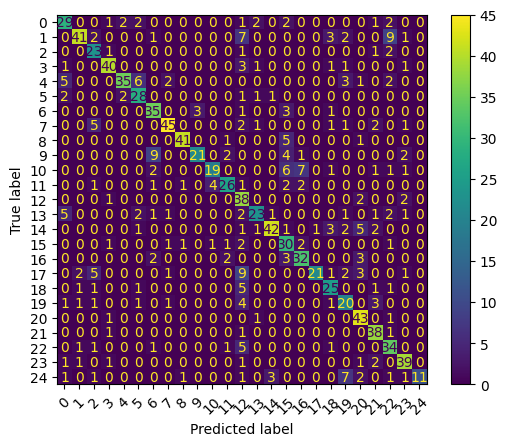

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        42
           1       0.87      0.62      0.73        66
           2       0.57      0.82      0.68        28
           3       0.85      0.83      0.84        48
           4       0.90      0.65      0.75        54
           5       0.68      0.80      0.74        35
           6       0.67      0.81      0.74        43
           7       0.88      0.78      0.83        58
           8       0.93      0.85      0.89        48
           9       0.88      0.54      0.67        39
          10       0.79      0.50      0.61        38
          11       0.79      0.68      0.73        38
          12       0.44      0.88      0.59        43
          13       0.77      0.57      0.66        40
          14       0.89      0.71      0.79        59
          15       0.54      0.75      0.63        40
          16       0.73      0.76      0.74        42
          17       0.95    

In [17]:
trainer.save_model("/kaggle/working/efficientnet_model")